In [1]:
%matplotlib inline
import torch
from torch import nn
import torchvision
from d2l import torch as d2l

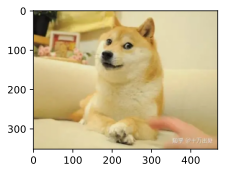

In [2]:
d2l.set_figsize()
img=d2l.Image.open('../img/dog.jpg')
d2l.plt.imshow(img);

In [3]:
def apply(img,aug,num_rows=2,num_cols=4,scale=1.5):
    Y=[aug(img) for _ in range(num_rows*num_cols)]
    d2l.show_images(Y,num_rows,num_cols,scale=scale)

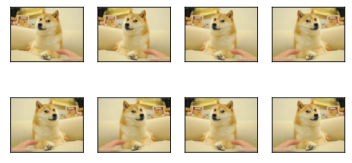

In [4]:
apply(img,torchvision.transforms.RandomHorizontalFlip())  #水平翻转

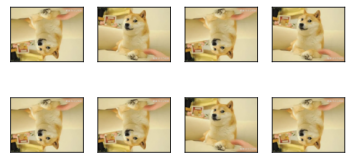

In [5]:
apply(img,torchvision.transforms.RandomVerticalFlip())   #上下翻转

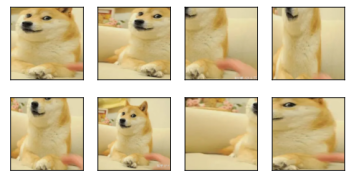

In [6]:
shape_aug=torchvision.transforms.RandomResizedCrop((200,200),scale=(0.1,1),ratio=(0.5,2))
apply(img,shape_aug)

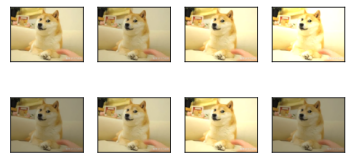

In [7]:
apply(img,torchvision.transforms.ColorJitter(brightness=0.5,contrast=0,saturation=0,hue=0))

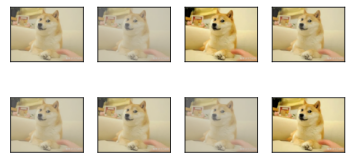

In [8]:
apply(img,torchvision.transforms.ColorJitter(brightness=0,contrast=0.5,saturation=0,hue=0))

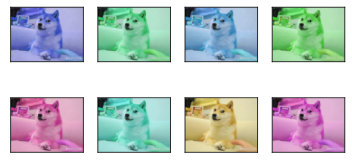

In [9]:
apply(img,torchvision.transforms.ColorJitter(brightness=0,contrast=0,saturation=0,hue=0.5))

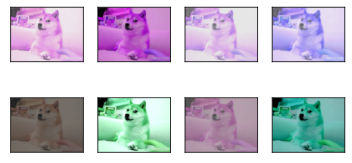

In [10]:
color_aug=torchvision.transforms.ColorJitter(brightness=0.5,contrast=0.5,saturation=0.5,hue=0.5)
apply(img,color_aug)

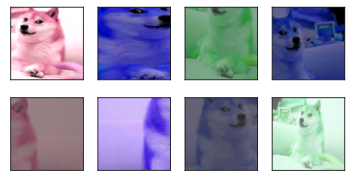

In [11]:
augs=torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(), color_aug, shape_aug])
apply(img,augs)

Files already downloaded and verified


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

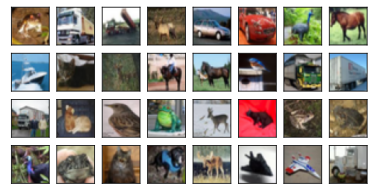

In [12]:
all_images= torchvision.datasets.CIFAR10(train=True,root='../data',download=True)
d2l.show_images([all_images[i][0] for i in range(32)],4,8,scale=0.8)

In [13]:
#ToTensor实例将一批图像转换为深度学习框架所要求的格式，即形状为（批量大小，通道数，高度，宽度）的32位浮点数，取值范围为0～1。
train_augs=torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),
                                          torchvision.transforms.ToTensor()])
test_augs=torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [14]:
def load_cifar10(is_train,augs,batch_size):
    dataset=torchvision.datasets.CIFAR10(root='../data',train=is_train,transform=augs,download=True)
    dataloader=torch.utils.data.DataLoader(dataset,batch_size=batch_size,
                                                shuffle=is_train,num_workers=d2l.get_dataloader_workers())
    return dataloader

In [18]:
#多GPU训练
def train_batch_ch13(net,X,y,loss,trainer,devices):
    if isinstance(X,list):
        X=[x.to(devices[0]) for x in X]
    else:
        X.to(devices[0])
    y=y.to(devices[0])
    net.train()
    trainer.zero_grad()
    y_hat=net(X)
    l=loss(y_hat,y)
    l.sum().backward()
    trainer.step()
    train_loss_sum=l.sum()
    train_acc_sum=d2l.accuracy(y_hat,y)  #计算正确的个数
    return train_loss_sum,train_acc_sum

def train_ch13(net,train_iter,test_iter,loss,trainer,num_epochs,devices=d2l.try_all_gpus()):
    timer,num_batches=d2l.Timer(),len(train_iter)
    animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0,1],legend=['train loss','train_acc','test acc'])
    #nn.DataParallel工作原理是将模型复制到每个 GPU 上，并将输入数据分成较小的批次，在每个 GPU 上并行处理。
    #每次前向传递后，梯度会在所有 GPU 上聚合，并用于更新模型参数。
    net=nn.DataParallel(net,device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        #训练损失，训练准确度，实例数，特点数
        metric=d2l.Accumulator(4)
        for i,(features,labels) in enumerate(train_iter):
            timer.start()
            l,acc=train_batch_ch13(net,features,labels,loss,trainer,devices)
            metric.add(l,acc,labels.shape[0],labels.numel())
            timer.stop()
            if (i+1)%(num_batches//5)==0 or i==(num_batches-1):
                animator.add(epoch+(i+1)/num_batches,(metric[0]/metric[2],metric[1]/metric[3],None))
        test_acc=d2l.evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch+1,(None,None,test_acc))
    print(f'loss:{metric[0]/metric[2]:.3f},train acc {metric[1]/metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2]*num_epochs/timer.sum():.1f}example/sec on {str(devices)}')

In [21]:
batch_size,devices,net=128,d2l.try_all_gpus(),d2l.resnet18(10,3)
def init_weights(m):
    if type(m) in [nn.Linear,nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)

def train_with_data_aug(train_augs,test_augs,batch_size,net,lr=0.001):
    train_iter=load_cifar10(is_train=True,augs=train_augs,batch_size=batch_size)
    test_iter=load_cifar10(False,test_augs,batch_size)
    loss=nn.CrossEntropyLoss(reduction="none")
    trainer=torch.optim.Adam(net.parameters(),lr=lr)
    train_ch13(net,train_iter,test_iter,loss,trainer,10,devices)

loss:0.168,train acc 0.942, test acc 0.833
563.3example/sec on [device(type='cuda', index=0)]


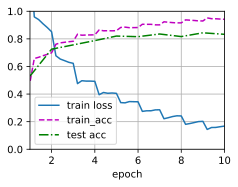

In [22]:
train_with_data_aug(train_augs,test_augs,batch_size,net)